<h1>CSCE 439 Final Project Source Code

<h2> 1. Installing the Dataset

In [ ]:
pip install ucimlrepo


<h2> 2. Train Model on RFC

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
           "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
           "hours_per_week", "native_country", "income"]
data = pd.read_csv(url, header=None, names=columns, na_values=" ?", skipinitialspace=True)

# Drop rows with missing values
data.dropna(inplace=True)

X = data.drop(["income", "fnlwgt"], axis=1)
y = data["income"].apply(lambda x: 1 if x == ">50K" else 0)

# 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: categorical and numerical features
categorical_features = X.select_dtypes(include=["object"]).columns
numerical_features = X.select_dtypes(exclude=["object"]).columns

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# Model pipeline
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    ))
])

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.94      0.84      0.88      4942
           1       0.62      0.83      0.71      1571

    accuracy                           0.83      6513
   macro avg       0.78      0.83      0.80      6513
weighted avg       0.86      0.83      0.84      6513



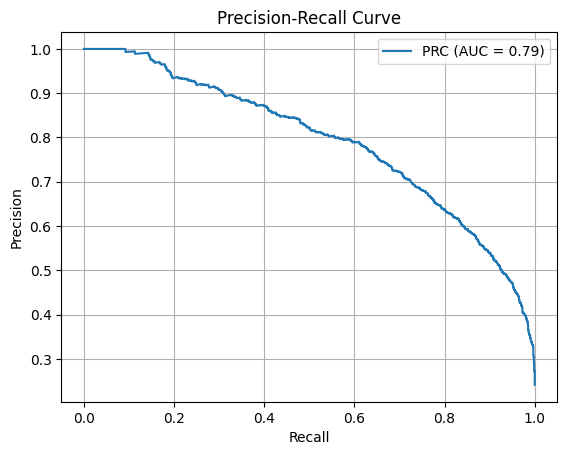

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Get predicted probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calculate the area under the curve
prc_auc = auc(recall, precision)

# Plot the PRC
plt.figure()
plt.plot(recall, precision, label=f'PRC (AUC = {prc_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


<h2> 3. Identify Feature Importance

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import pandas as pd

# Extract numerical and categorical features
categorical_features = X.select_dtypes(include=["object"]).columns
numerical_features = X.select_dtypes(exclude=["object"]).columns

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features)
])

# Updated model pipeline
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    ))
])

# Train and fit the model
model.fit(X_train, y_train)

# Get feature importance
feature_names = numerical_features.tolist() + categorical_features.tolist()
importances = model.named_steps['classifier'].feature_importances_
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance.head(20))  # Top 20 features


           Feature  Importance
7   marital_status    0.165931
9     relationship    0.157104
0              age    0.154665
1    education_num    0.112554
2     capital_gain    0.102801
4   hours_per_week    0.085004
8       occupation    0.061508
6        education    0.042391
5        workclass    0.033435
3     capital_loss    0.030306
11             sex    0.021666
12  native_country    0.017760
10            race    0.014876


<h2> 4. Inference Attacks

In [ ]:
# Function to create models to predict individual attributes
def inference_attack_models(data, target_attributes, drop_features):
    results = {}
    for attribute in target_attributes:
        # Exclude the target attribute from features
        X = data.drop(drop_features + [attribute], axis=1)
        y = data[attribute]
        target_names = pd.unique(y)

        # Encode target attribute if categorical
        if y.dtype == 'object':
            y = pd.factorize(y)[0]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Preprocessing pipeline
        categorical_features = X.select_dtypes(include=["object"]).columns
        numerical_features = X.select_dtypes(exclude=["object"]).columns


        preprocessor = ColumnTransformer([
            ("num", StandardScaler(), numerical_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
        ])

        model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    ))
])

        # Train and evaluate the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(target_names)

        # Store results
        results[attribute] = classification_report(y_test, y_pred, output_dict=True)

    return results

# List of attributes to predict (target attributes)
target_attributes = ["sex"]
#target_attributes = ["sex", "education", "relationship", "race", "age", "occupation"]

# Attributes to drop while training each model
drop_features = ["income", "fnlwgt"]  # Income and other irrelevant features for these attacks

# Run inference attacks
inference_results = inference_attack_models(data, target_attributes, drop_features)

#Print the classification reports for each attribute
# for attribute, report in inference_results.items():
#     print(f"--- Classification Report for {attribute} ---")
#     print(pd.DataFrame(report).transpose())
#     print("\n")


['Male' 'Female']


In [ ]:
import pandas as pd

def process_compiled_reports(reports):
    processed_reports = {}

    for attribute, report in reports.items():
        # Convert the report to DataFrame
        report_df = pd.DataFrame(report).transpose()

        # Filter out classes with support < 50 or >= 6513
        filtered_df = report_df[(report_df["support"] >= 50) & (report_df["support"] < 6513)]

        # Calculate total filtered support
        total_filtered_support = filtered_df["support"].sum()

        # Calculate the number of correct predictions (precision * support) and total support
        total_correct = (filtered_df["precision"] * filtered_df["support"]).sum()

        # Recalculate accuracy
        accuracy = total_correct / total_filtered_support

        # Recalculate macro avg and weighted avg
        macro_avg = {
    "precision": filtered_df["precision"].mean(),
    "recall": filtered_df["recall"].mean(),
    "f1-score": filtered_df["f1-score"].mean(),
    "support": total_filtered_support,
}
  # Average across valid classes

        weighted_avg = {
            "precision": (filtered_df["precision"] * filtered_df["support"]).sum() / total_filtered_support,
            "recall": (filtered_df["recall"] * filtered_df["support"]).sum() / total_filtered_support,
            "f1-score": (filtered_df["f1-score"] * filtered_df["support"]).sum() / total_filtered_support,
            "support": total_filtered_support,  # Same support for weighted avg
        }

        # Add recalculated rows
        filtered_df.loc["accuracy"] = {
            "precision": (filtered_df["recall"] * filtered_df["support"]).sum() / total_filtered_support,
            "recall": (filtered_df["recall"] * filtered_df["support"]).sum() / total_filtered_support,
            "f1-score": (filtered_df["recall"] * filtered_df["support"]).sum() / total_filtered_support,
            "support": (filtered_df["recall"] * filtered_df["support"]).sum() / total_filtered_support,
        }
        filtered_df.loc["macro avg"] = macro_avg
        filtered_df.loc["weighted avg"] = weighted_avg

        # Save processed report
        processed_reports[attribute] = filtered_df

    return processed_reports




# Process all reports
processed_reports = process_compiled_reports(inference_results)

# Print adjusted reports
for attribute, report in processed_reports.items():
    print(f"--- Processed Classification Report for {attribute} ---")
    print(report)
    print("\n")



--- Processed Classification Report for sex ---
              precision    recall  f1-score      support
0              0.960091  0.767723  0.853198  4387.000000
1              0.660899  0.934149  0.774118  2126.000000
accuracy       0.822048  0.822048  0.822048     0.822048
macro avg      0.810495  0.850936  0.813658  6513.000000
weighted avg   0.862428  0.822048  0.827385  6513.000000




<ipython-input-21-091a05b3648b>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc["accuracy"] = {
<ipython-input-21-091a05b3648b>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc["macro avg"] = macro_avg
